# Project structure

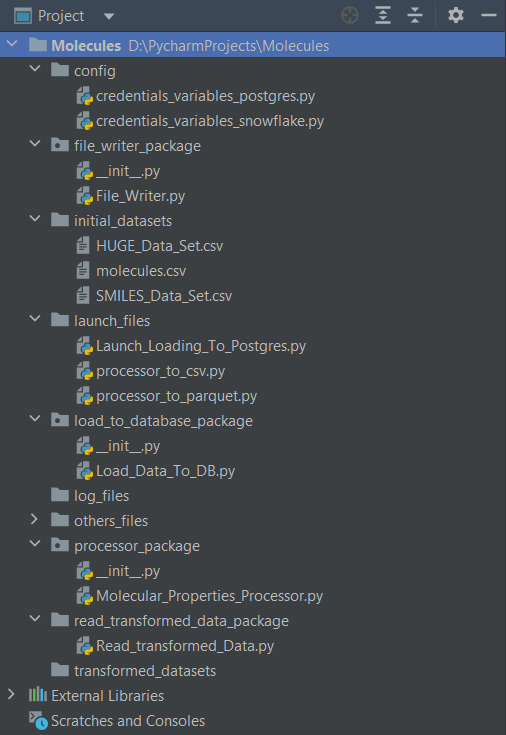

In [ ]:
TODO:
1. think about other columns which may contain corrupted data according to requirements
(exceptions or checks in code)
2. Add logging
3. think how to implement threading in File_Writer and Load_To_DB modules (I/O tasks)
4. think about column names transformation before loading data to DB (column names in the same pattern)
5. think about particular exceptions


In [ ]:
# Molecular_Properties_Processor.py

import re
import multiprocessing
from joblib import Parallel, delayed  # simple parallel computing
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import math
from datetime import datetime


class MoleculeProcessingException(Exception):
    pass

class MoleculeDecodingException(Exception):
    """Return special message when UnicodeDecodeError occurred

    Condition: during reading file in the  _read_input_data() method
    in case if error_status was not specified and a decoding error occurred.
    """
    def __init__(self, message, input_file_path, encoding):
        self.message = message
        self.input_file_path = input_file_path
        self.encoding = encoding

    def __str__(self):
        return f'UnicodeDecodeError occurred during reading file {self.input_file_path}\n' \
               f' with {self.encoding} encoding.\nError: {self.message}.\nTry to provide error_status parameter.'

class MolecularPropertiesProcessor:

    """Class contains methods to perform some transformations with given dataset in csv format.

    General Steps:
    1. Read csv file and create dataframe.
    2. Prepare data:
        - find corrupted rows and drop them
        - drop duplicates
        - add necessary columns
    3. Return transformed dataframe which will be written in new file by using File_writer module.
    """

    def __init__(
            self,
            input_file_path: str,
            encoding: str,  # encoding for pd.read_csv() to decode special symbols
            process_amount: int,  # determine number of processes to process data
            chunk_size: int,  # row amount in each chunk
            error_file_path: str,  # Path to the file where problematic rows will be written
            error_status: str  # status for encoding_errors in pd.read_csv()
    ):
        self.input_file_path = input_file_path
        self.encoding = encoding
        self.process_amount = process_amount
        self.chunk_size = chunk_size
        self.error_file_path = error_file_path
        self.error_status = error_status

        self.smiles_col = None  # mail column to get necessary attributes (new columns) from rdkit
        self.mols_df = self._read_input_data()

    def _write_error_to_file(self, error_message):
        """Write the given error message to the error file.

        File with errors helps to determine corrupted rows."""
        error_time = datetime.now()
        with open(self.error_file_path, 'a') as f:
            f.write(f'Error time:\n{error_time}\n')
            f.write(error_message + '\n')

    def _read_input_data(self):
        """Read provided csv file with given data"""
        if self.error_status is None:
            try:
                self.mols_df = pd.read_csv(self.input_file_path, encoding=self.encoding)
                return self.mols_df
            except UnicodeDecodeError as e:
                error_message = f"UnicodeDecodeError: {e}\nProblematic Row:\n{e.object}\n\n"
                # Write the error message to the error file
                self._write_error_to_file(error_message)
                # and raise exception with contain help message to determine the problem
                raise MoleculeDecodingException(e, self.input_file_path, self.encoding)
        else:
            self.mols_df = pd.read_csv(self.input_file_path, encoding=self.encoding, encoding_errors=self.error_status)
            return self.mols_df

        if self.mols_df.empty:
            raise MoleculeProcessingException('Something went wrong.\nDataframe is empty.')


    def _column_finder(self, match_str, df):
        """'Smiles' column is the main column to find  formula in rdkit library.

         This column may have different name formats in dataframe.
         But it contains word 'smiles'.
         Method allows to find this column to perform future transformations.
         """
        matcher = re.compile(match_str, re.IGNORECASE)
        column_to_find = next(filter(matcher.match, df.columns))
        if not column_to_find:
            raise MoleculeProcessingException(f"No {match_str} column found in a dataframe")
        return column_to_find

    def _prepare_data(self):
        # TODO: think about other columns which may contain corrupted data according to requirements.
        """Prepare dataframe to adding new properties.

        Drop duplicates.
        Check corrupted data and drop it.
        """
        try:
            # find 'smiles' column in dataframe
            self.smiles_col = self._column_finder(r'smiles', self.mols_df)

            row_count_b = len(self.mols_df)
            print(f'Total row count before deleting duplicates{row_count_b}')

            self.mols_df.drop_duplicates(subset=self.smiles_col, inplace=True)

            row_count_a = len(self.mols_df)
            print(f'Total row count after deleting duplicates{row_count_a}')
        except MoleculeProcessingException as e:
            error_message = f"An error occurred during data preparation: {e}\n"
            # Write the error message to the error file
            self._write_error_to_file(error_message)

        # Handle parse errors and drop corresponding rows
        invalid_smiles_indices = []  # list to write indexes of corrupted rows
        for idx, smiles in self.mols_df[self.smiles_col].items():  # use 'smiles' col to find bad rows
            try:
                # find given molecule in rdkit
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:  # means that this molecule does not exist -> corrupted row
                    invalid_smiles_indices.append(idx)
                    error_message = f'Parsing error in row with index: {idx}\n'
                    self._write_error_to_file(error_message)
            except Exception as e:
                invalid_smiles_indices.append(idx)
                error_message = f"Error: {e}\nInvalid SMILES in row {idx}\n"
                self._write_error_to_file(error_message)
        # drop bad rows
        if invalid_smiles_indices:
            self.mols_df.drop(index=invalid_smiles_indices, inplace=True)
            print(f"Dropped {len(invalid_smiles_indices)} rows with parse errors.")
            row_count_ap = len(self.mols_df)
            print(f'Total row count after deleting currupted rows {row_count_ap}')

    def _compute_molecule_properties_chunk(
            self,
            chunk_df: pd.DataFrame,
    ) -> pd.DataFrame:
        """ Compute molecule properties for chunk dataframe """
        chunk_df["mol"] = chunk_df[self.smiles_col].apply(lambda s: AllChem.MolFromSmiles(s))
        mol_props_funcs = {
            "Molecular weight": lambda mol: Descriptors.MolWt(mol),
            "TPSA": lambda mol: Descriptors.TPSA(mol),
            "logP": lambda mol: Descriptors.MolLogP(mol),
            "H Acceptors": lambda mol: Descriptors.NumHAcceptors(mol),
            "H Donors": lambda mol: Descriptors.NumHDonors(mol),
            "Ring Count": lambda mol: Descriptors.RingCount(mol),
            "Lipinski pass": lambda mol: all([
                Descriptors.MolWt(mol) < 500,
                Descriptors.MolLogP(mol) < 5,
                Descriptors.NumHDonors(mol) < 5,
                Descriptors.NumHAcceptors(mol) < 10
            ])
        }

        mol_props_to_compute = list(mol_props_funcs.keys())
        chunk_df[mol_props_to_compute] = chunk_df.apply(
            lambda row: [mol_props_funcs[prop](row["mol"]) for prop in mol_props_to_compute],
            axis=1,
            result_type="expand"
        )

        chunk_df.drop(columns=["mol"], inplace=True)
        chunk_df.set_index(self.smiles_col, inplace=True)

        return chunk_df

    def _compute_molecule_properties(self) -> pd.DataFrame:
        """
        Compute molecule properties and fingerprints using RDKit
        in chunks.
        """
        # Solution using Joblib as an alternative way 
        # Define the number of parallel jobs
        # num_jobs = multiprocessing.cpu_count()
        # #
        # # # Split the dataframe into chunks
        # chunk_size = self.chunk_size
        # chunks = [self.mols_df[i:i + chunk_size] for i in range(0, len(self.mols_df), chunk_size)]
        # #
        # # # Use joblib to parallelize the computation
        # prev_result = Parallel(n_jobs=num_jobs)(delayed(self._compute_molecule_properties_chunk)(chunk) for chunk in chunks)
        # # Concatenate the list of dataframes into a single dataframe
        # result = pd.concat(prev_result)
        # return result


        const_size_of_chunks = self.chunk_size
        max_amount_of_p = self.process_amount

        # calculate amount of chunks
        amount_of_chunk_df = math.ceil(len(self.mols_df) / const_size_of_chunks)

        if amount_of_chunk_df > max_amount_of_p:
            amount_of_chunk_df = max_amount_of_p - 1

        list_of_chunks = np.array_split(self.mols_df, amount_of_chunk_df)

        pool = multiprocessing.Pool(processes=amount_of_chunk_df)
        p_df = pool.map(self._compute_molecule_properties_chunk, list_of_chunks)

        list_of_p = [p for p in p_df]
        # TODO: think how to implement threading in File_Writer and Load_To_DB modules
        # ? leave chunks list for threading
        result = pd.concat(list_of_p)
        return result

    def process_data(self):
        self._prepare_data()
        try:
            if self.process_amount != 0 and self.chunk_size != 0:
                mol_properties_df = self._compute_molecule_properties()
            else:
                mol_properties_df = self._compute_molecule_properties_chunk(self.mols_df)

        except MoleculeProcessingException as e:
            print(e)
        return mol_properties_df




In [ ]:
# File_Writer

# TODO: since writing data to a file is I/O task --> think about threading

from abc import ABC, abstractmethod


class FileWriter(ABC):

    def __init__( self, output_file_name: str):
        self.output_file_name = output_file_name

    @abstractmethod
    def write_to_file(self, dataframe):
        pass


class WriteToCsv(FileWriter):
    """Write output result from MolecularPropertiesProcessor class to a CSV file"""

    def write_to_file(self, dataframe):
        dataframe.to_csv(self.output_file_name, index=True)
        print(f"Saved DataFrame to {self.output_file_name}")


class WriteToParquet(FileWriter):
    """Write output result from MolecularPropertiesProcessor class to a parquet file"""

    def write_to_file(self, dataframe):
        dataframe.to_parquet(self.output_file_name, index=True)
        print(f"Saved DataFrame to {self.output_file_name}")

In [ ]:
# processor_to_parquet.py

from processor_package.Molecular_Properties_Processor import MolecularPropertiesProcessor
from file_writer_package.File_Writer import WriteToParquet


if __name__ == '__main__':
    # read raw dataset
    mpp = MolecularPropertiesProcessor(input_file_path="../initial_datasets/molecules.csv",
                                       encoding='windows-1252',
                                       process_amount=0,  # test on small dataset->not necessary to create several processes
                                       chunk_size=0,
                                       error_file_path='molecule_error.txt',
                                       error_status='ignore')

    # transform data and return a dadaframe
    mol_properties_df = mpp.process_data()

    # Write the processed data to a CSV file
    writer = WriteToParquet(output_file_name="../molecules_transformed.parquet")
    writer.write_to_file(mol_properties_df)

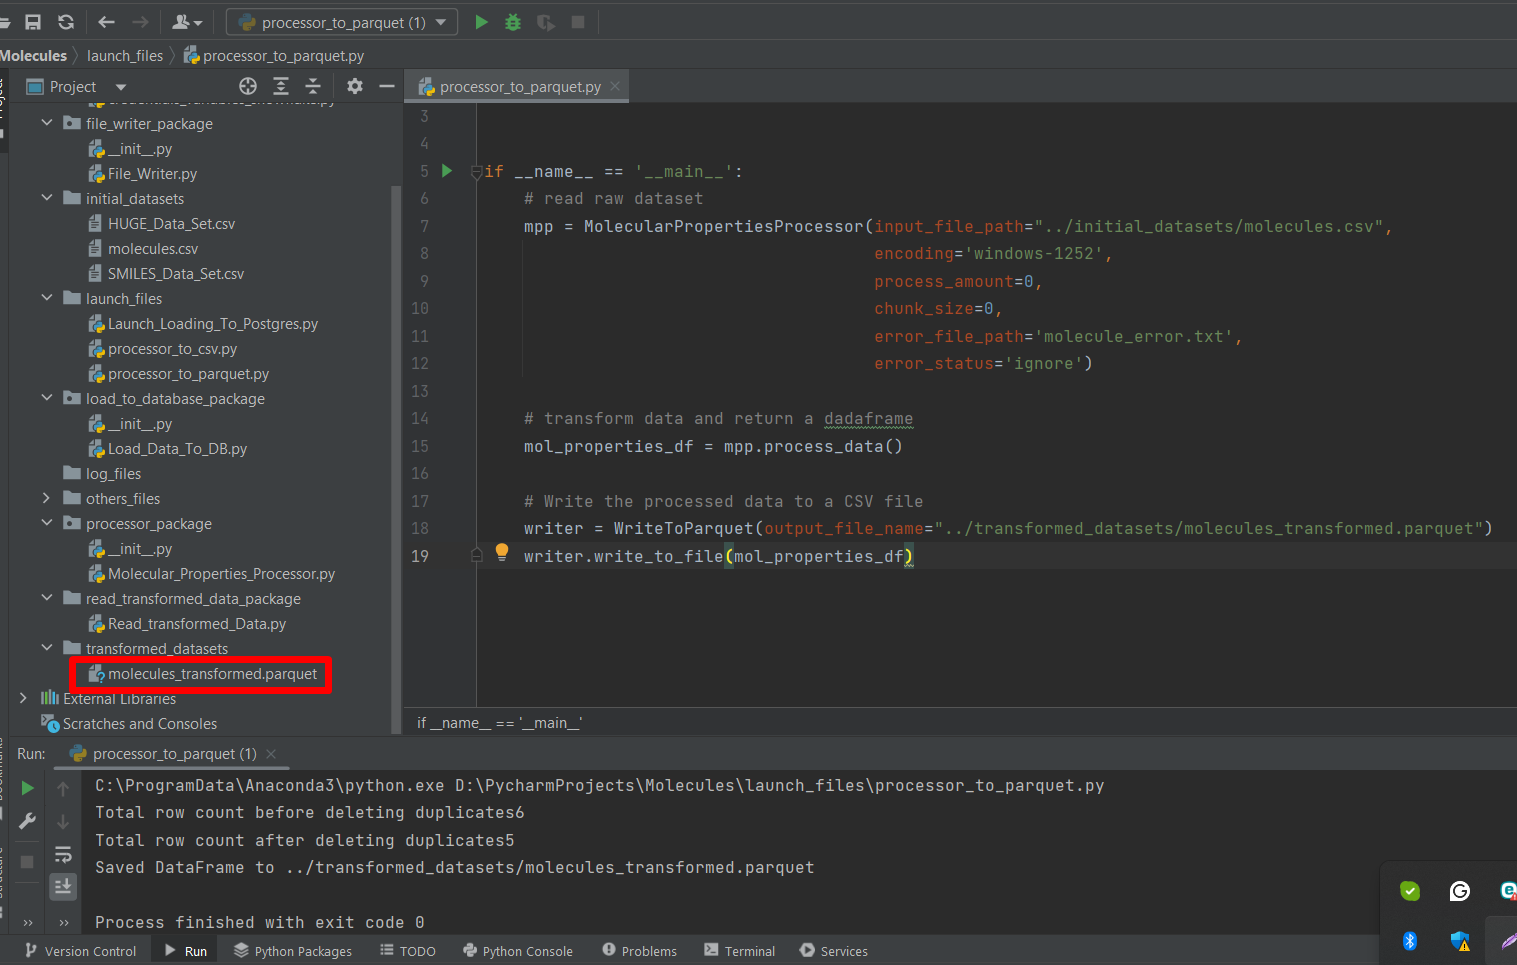

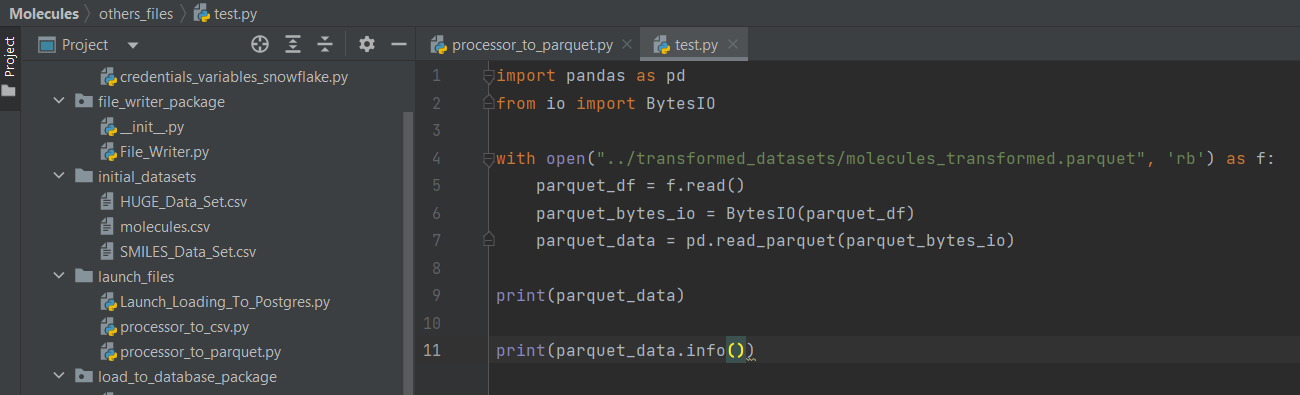

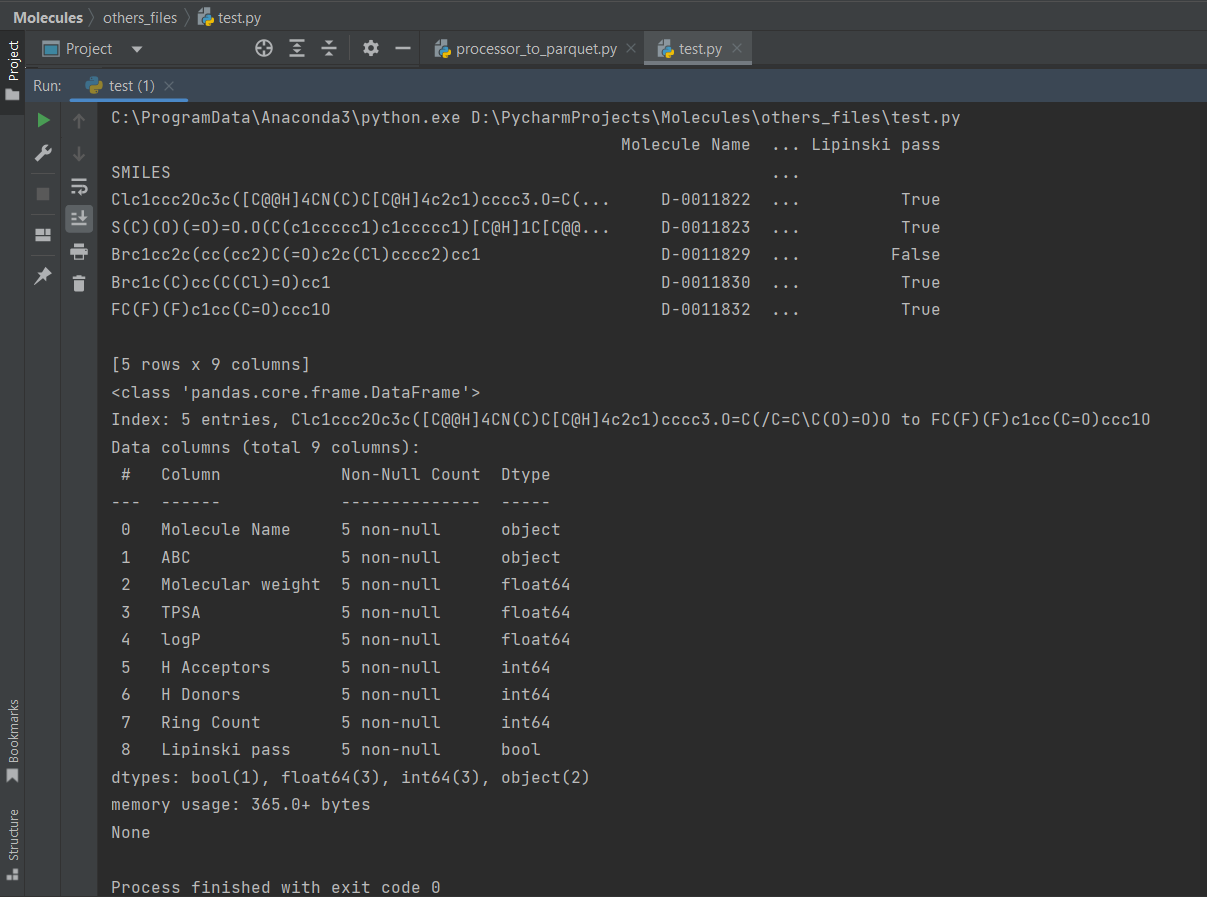

Since we can have datasets with different size I decided to introduce 'process_amount' and 'chunk_size' parametes manually.
It will depend on  the size of the dataset and the computational resources available

For very small datasets the overhead of creating and managing multiple processes might outweigh the benefits of parallelism. 
In such cases, processing the data serially might be faster especially in case of CPU tasks.

In case I/O-bound tasks (such as file I/O, network calls), parallelizing the workload could lead to significant performance gains, even for small datasets. Multiprocessing can utilize multiple CPU cores efficiently, thus speeding up the overall processing time --> TODO: think about may be for writing data to file or load to database it will be beneficial leave multiprocessing or multithreading (aslo create changeble parameters).
** For now multiprocessing/multithreading for these functionalities does not implemented in code.

If OS has multiple CPU cores available and sufficient memory, multiprocessing can effectively utilize these resources. 
However, if system has limited resources, creating too many processes might lead to resource contention and slowdowns.

#### For now in code implemented multiprocessing for datatransformation task.
Let`s see various cases.

Dataset:
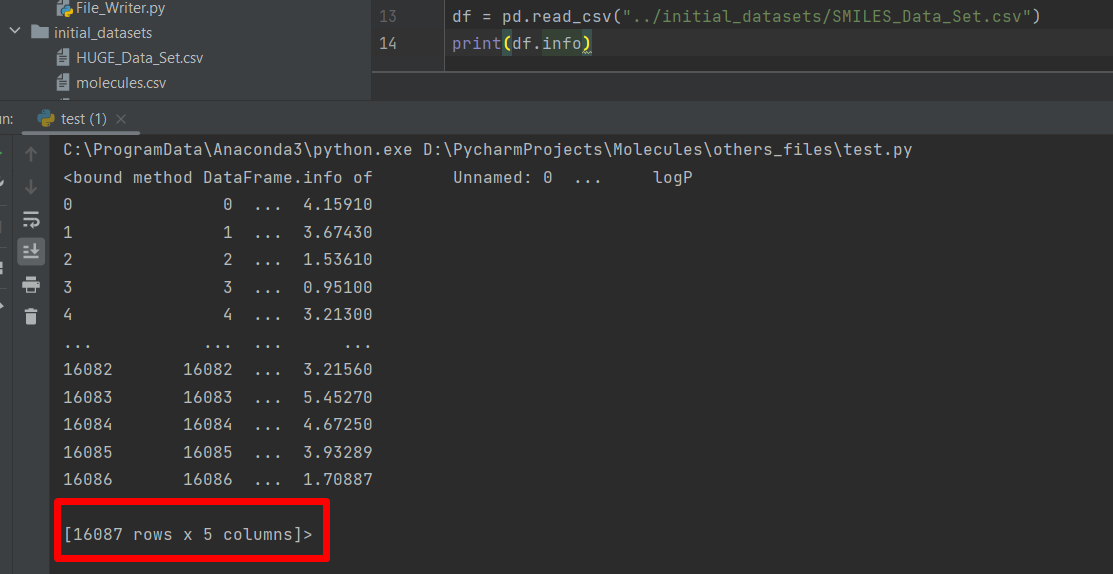

In [ ]:
# processor_to_csv.py

import pandas as pd
import time
from processor_package.Molecular_Properties_Processor import MolecularPropertiesProcessor
from file_writer_package.File_Writer import WriteToCsv


if __name__ == '__main__':
    mpp = MolecularPropertiesProcessor(input_file_path="../initial_datasets/SMILES_Data_Set.csv",
                                       encoding='windows-1252',
                                       process_amount=0, 
                                       chunk_size=0,
                                       error_file_path='../log_files/molecule_error.txt',
                                       error_status='ignore')
    start_t = time.time()
    mol_properties_df = mpp.process_data()  # Process the data
    end_t = time.time()

    # Write the processed data to a CSV file
    writer = WriteToCsv(output_file_name="smiles.csv")
    writer.write_to_file(mol_properties_df)

    df = pd.read_csv('smiles.csv')
    row_count_o = len(df)
    unique_smiles = df['SMILES'].nunique()
    print(f'Total row count after deleting duplicates: {row_count_o} and unique smiles: {unique_smiles}')
    # to compare result with different quantity of processes
    print('Process takes', end_t - start_t, ' seconds')

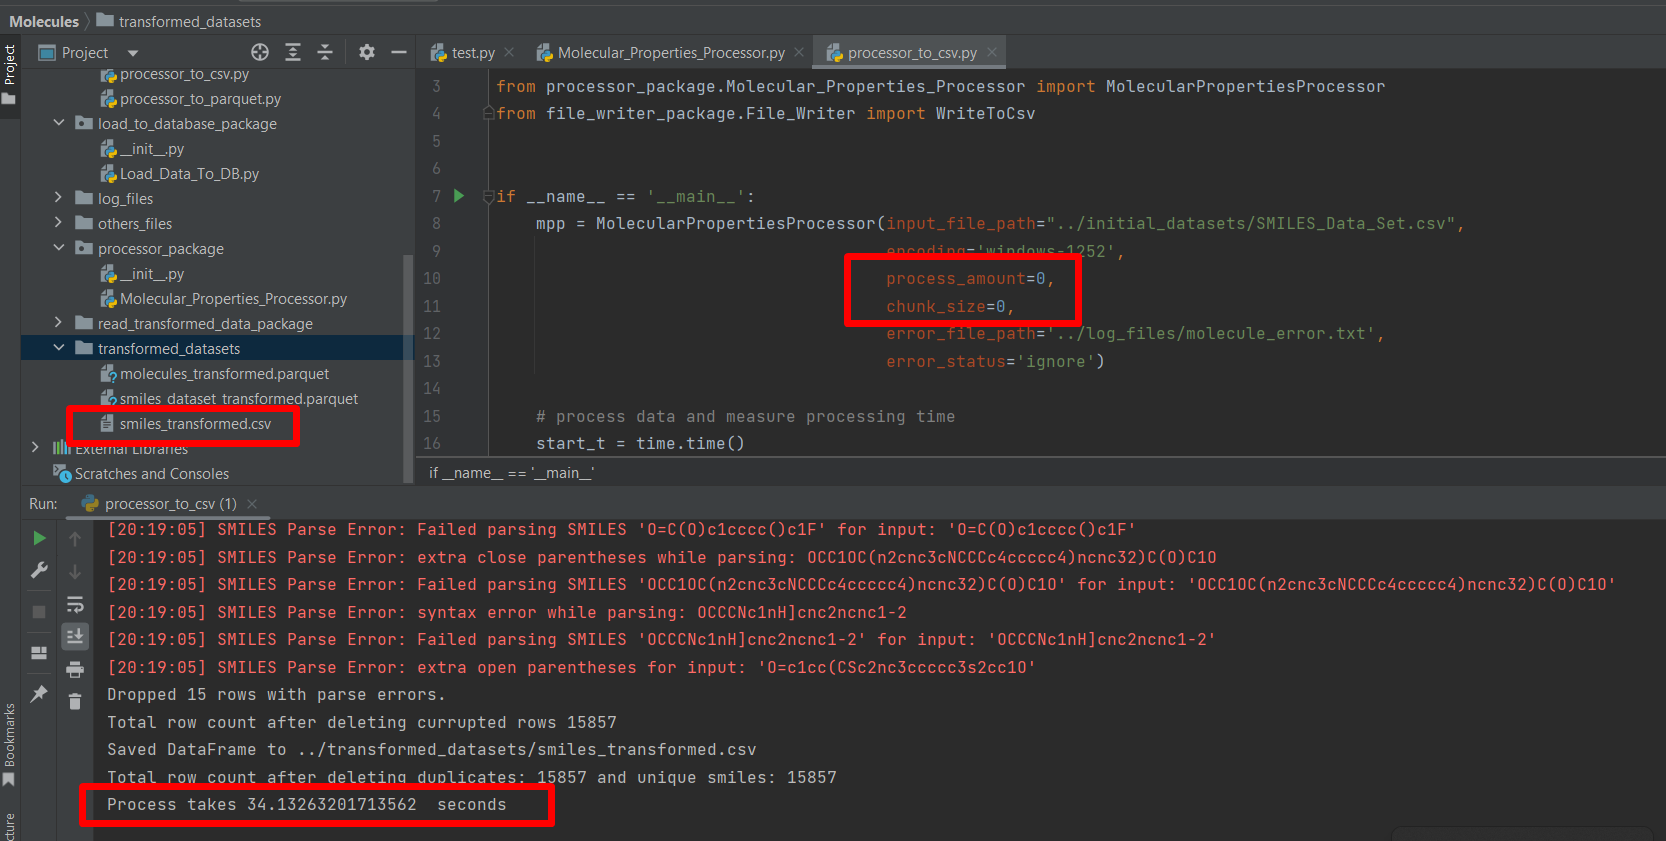

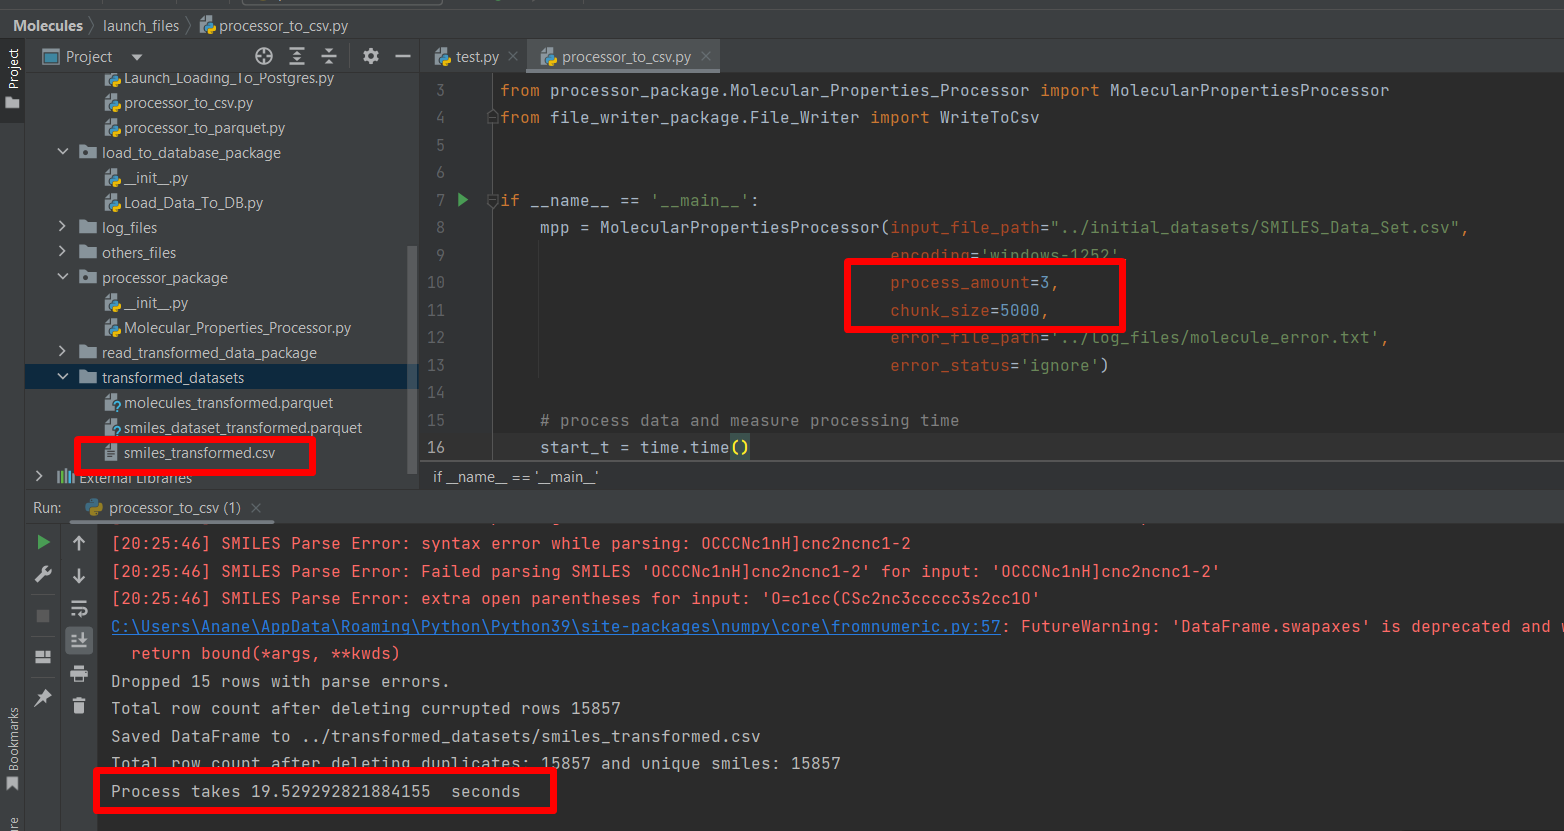

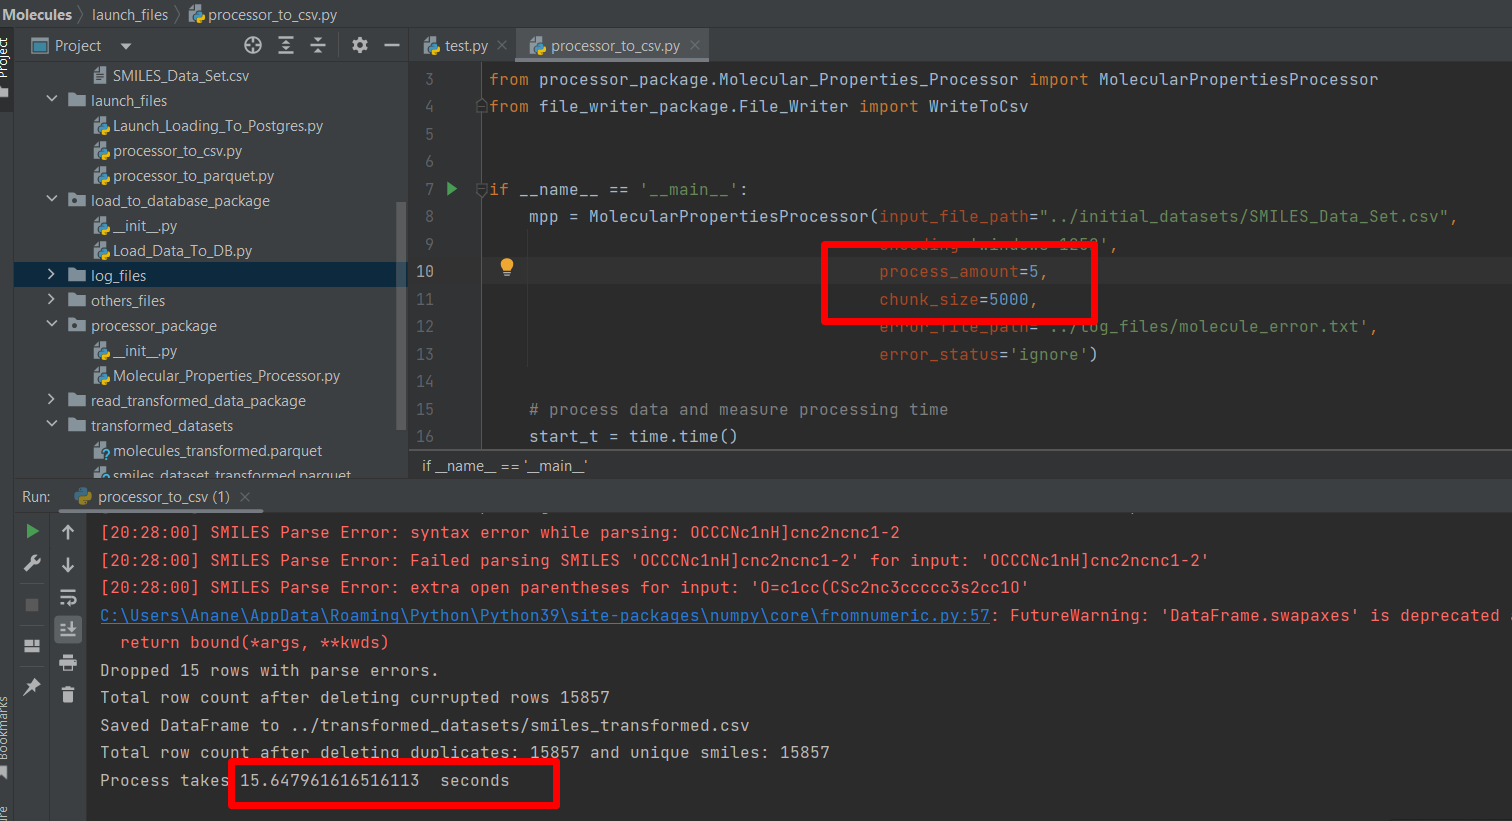

According to these tests we can consider that implementing multiprocessing for data transformation in this case is valuable and can improve performance.

Also, all rows with corrupted data were written to separate txt file.

This method works correctly:

 def _write_error_to_file(self, error_message):
        """Write the given error message to the error file.

        File with errors helps to determine corrupted rows."""
        error_time = datetime.now()
        with open(self.error_file_path, 'a') as f:
            f.write(f'Error time:\n{error_time}\n')
            f.write(error_message + '\n')
            
We can use this information to rapidly find errors (with corrupted data) in initial dataset (as example).

*In future also possible to implement logging functionality.

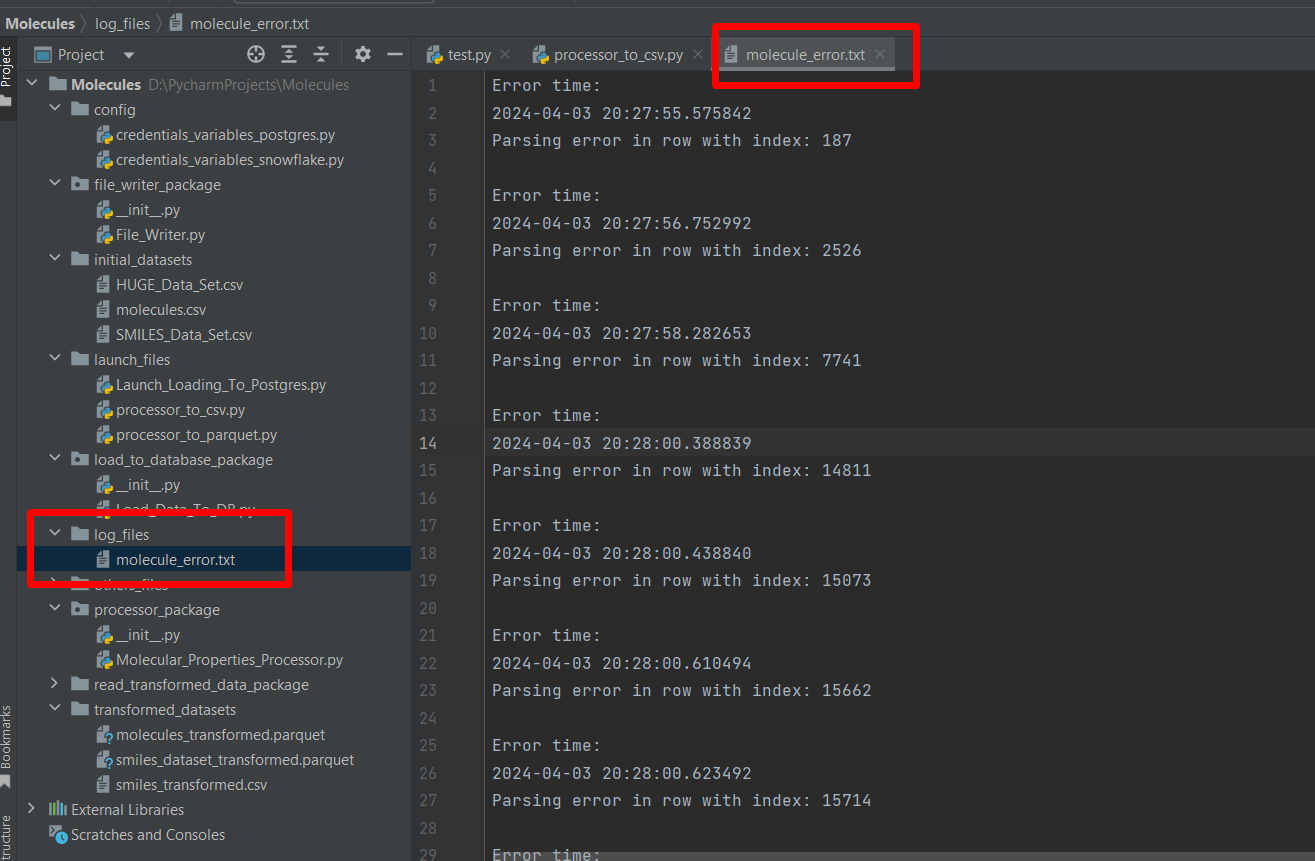

In [ ]:
# credential_variables_postgres.py

username = 'postgres'
password = ...
host = 'localhost'
database = 'molecules'
port = 5432

In [ ]:
# Load_Data_To_DB.py

# TODO: since inserting data to a database is I/O task --> think about threading/async?
# TODO: think about column names transformation before loading

from abc import ABC, abstractmethod
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Table, Boolean
from contextlib import contextmanager
import pandas as pd
from sqlalchemy.exc import IntegrityError


class DatabaseLoadException(Exception):
    pass

class LoadToDatabase(ABC):
    def __init__(self, file_name: str, credentials: str):
        self.file_name = file_name
        self.credentials = credentials

    @abstractmethod
    def db_engine(self, credentials: str):
        """Create engine to connect to database"""
        pass

    @abstractmethod
    def map_table(self, dataframe):
        """Extract columns names from dataframe to create new table."""
        pass

    @abstractmethod
    def create_table(self, table_name, dataframe, schema='public'):
        """Generate ddl script to create a new table in database."""
        self.table_name = table_name
        self.dataframe = dataframe
        self.schema = schema
        pass

    @abstractmethod
    def get_session(self):
        """Provide a transactional scope around a series of operations."""
        pass

    @abstractmethod
    def insert_data(self):
        """Load transformed data from generated to database."""
        pass

    # TODO: think about how to check wheather the table exists in Database
    @abstractmethod
    def if_exists_table_in_db(self):
        pass


class LoadDataToPostgres(LoadToDatabase):

    def db_engine(self, credentials):
        try:
            engine = create_engine(self.credentials)
            return engine
        except Exception as e:  # TODO: thonk about particular exceptions which may occur
            raise DatabaseLoadException(f'An error occurred: {e}')

    def map_table(self, dataframe):
        # extract necessary columns from df
        columns = {column: self.get_column_data_type(dataframe[column]) for column in dataframe.columns}

        return columns

    def create_table(self, table_name, dataframe, columns, schema='public'):
        metadata = MetaData(schema=schema)

        # Create Column objects for each column in the dictionary
        table_columns = [Column(name, dtype) for name, dtype in columns.items()]

        # Create the table using the provided table_name, metadata, and columns
        table = Table(table_name, metadata, *table_columns)

        # Create the table in the database
        ddl_create_table = metadata.create_all(self.db_engine(self.credentials))

        # Return the created table
        return table

    def get_column_data_type(self, column_series):
        """Map pandas data types to SQLAlchemy data types."""
        types = {
            'int64': Integer,
            'float64': Integer,
            'object': String,
            'bool': Boolean
        }

        # Get the data type of the column and map it to SQLAlchemy type
        pandas_data_type = str(column_series.dtype)
        sqlalchemy_data_type = types.get(pandas_data_type, String)

        return sqlalchemy_data_type()

    @contextmanager
    def get_session(self):
        from sqlalchemy.orm import sessionmaker
        Session = sessionmaker()
        Session.configure(bind=self.db_engine(self.credentials))
        session = Session()

        try:
            yield session
            session.commit()
        except:
            session.rollback()
            raise DatabaseLoadException(f'Session is rollbacked. An error occur.')
        finally:
            session.close()

    def insert_data(self, table_name, dataframe, schema='public'):
        with self.get_session() as session:
            # Load the table metadata from the existing table
            metadata = MetaData(schema=schema)
            table = Table(table_name, metadata, autoload=True, autoload_with=self.db_engine(self.credentials))

            # Iterate through the DataFrame rows and insert them into the table
            for _, row in dataframe.iterrows():
                record = {key: value for key, value in row.items() if key in table.columns}
                try:
                    session.execute(table.insert().values(record))
                except IntegrityError:  # TODO: think about particular exceptions
                    session.rollback()
                    print("Integrity Error: Duplicate record or missing required field.")
                except Exception as e:
                    session.rollback()
                    print("An error occurred:", e)


class LoadDataToSnowflake(LoadToDatabase):

    def get_session(self):
        from snowflake.snowpark import Session
        pass

In [ ]:
# Read_Transformed_Data.py

from abc import ABC, abstractmethod
import pandas as pd
from io import BytesIO


class ReadFile(ABC):

    def __init__(
            self, file_name: str):
        self.file_name = file_name
    """Class allows to read transformed data from different file formats.
    
    Then load them to database."""
    @abstractmethod
    def read_file(self):
        pass

class ReadCsv(ReadFile):

    def read_file(self):
        csv_data = pd.read_csv(self.file_name)
        return csv_data


class ReadParquet(ReadFile):

    def read_file(self):
        with open(self.file_name, 'rb') as f:
            parquet_df = f.read()
        parquet_bytes_io = BytesIO(parquet_df)
        parquet_data = pd.read_parquet(parquet_bytes_io)

        return parquet_data

In [ ]:
# Launch_Loading_To_Postgres.py

from load_to_database_package.Load_Data_To_DB import LoadDataToPostgres
from config.credentials_variables_postgres import username, password, host, database, port
from read_transformed_data_package.Read_transformed_Data import ReadCsv

if __name__ == '__main__':
    data_to_load = ReadCsv(file_name="smiles.csv")

    credentials = f"postgresql://{username}:{password}@{host}:{port}/{database}"

    # Create an instance of LoadDataToPostgres
    data_loader = LoadDataToPostgres(file_name="smiles.csv",
                                     credentials=credentials)

    # Map table columns and types
    columns_info = data_loader.map_table(data_to_load.read_file())

    # Create the table in the database
    data_loader.create_table('molecule_characteristic_2', dataframe=data_to_load.read_file(), columns=columns_info)

    # Insert data into the database
    data_loader.insert_data(table_name='molecule_characteristic_2', dataframe=data_to_load.read_file())

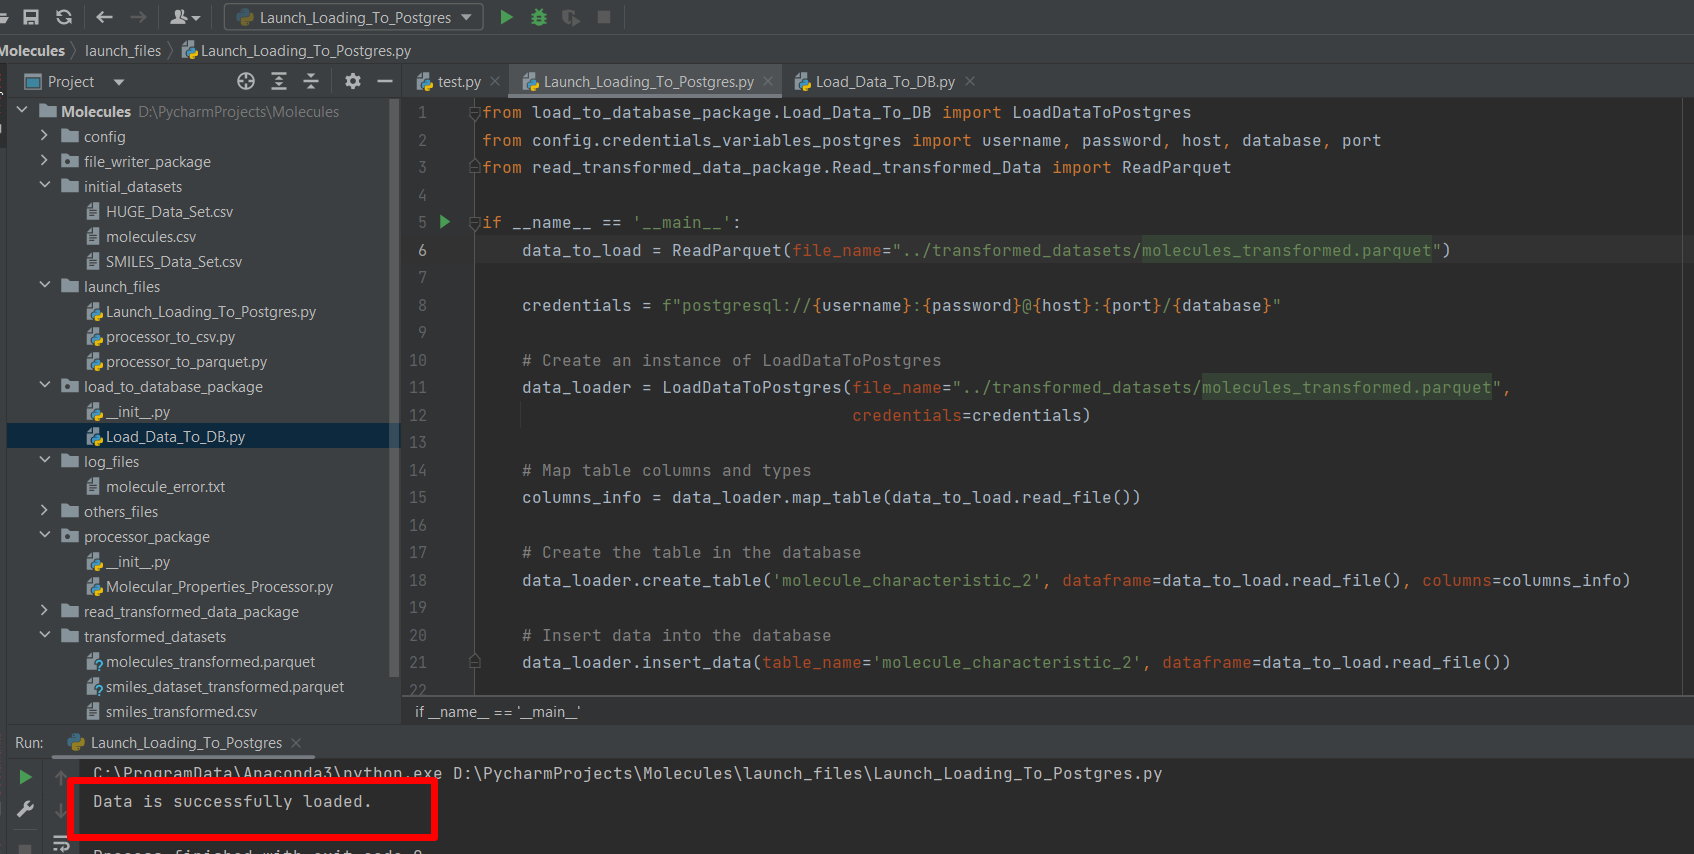

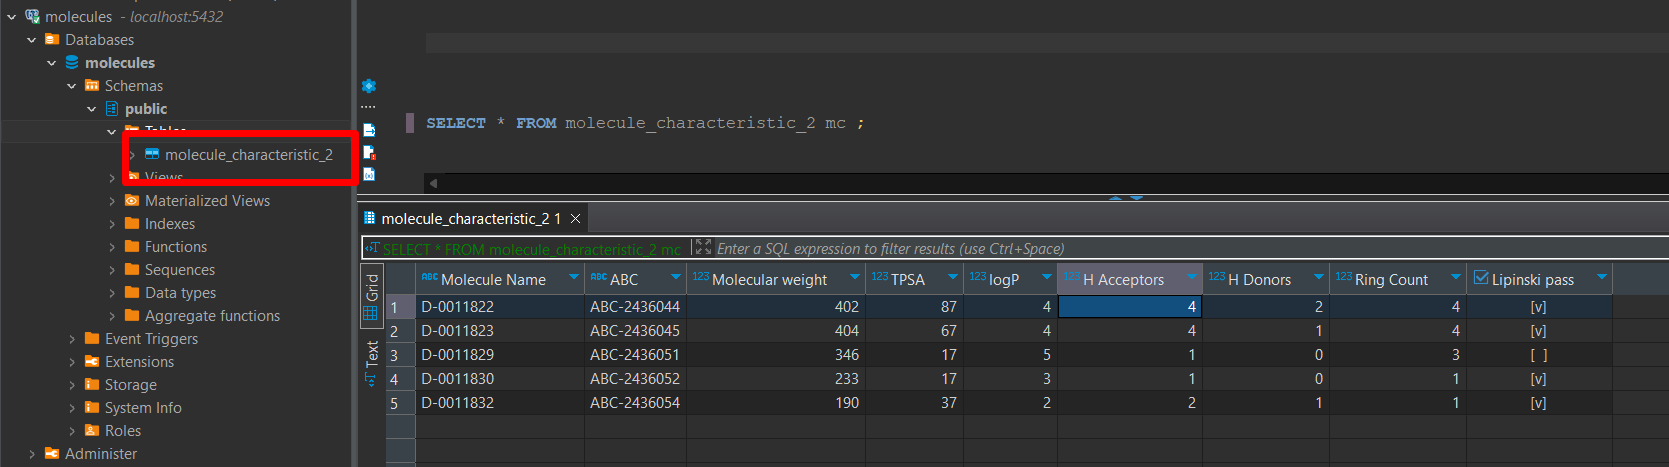

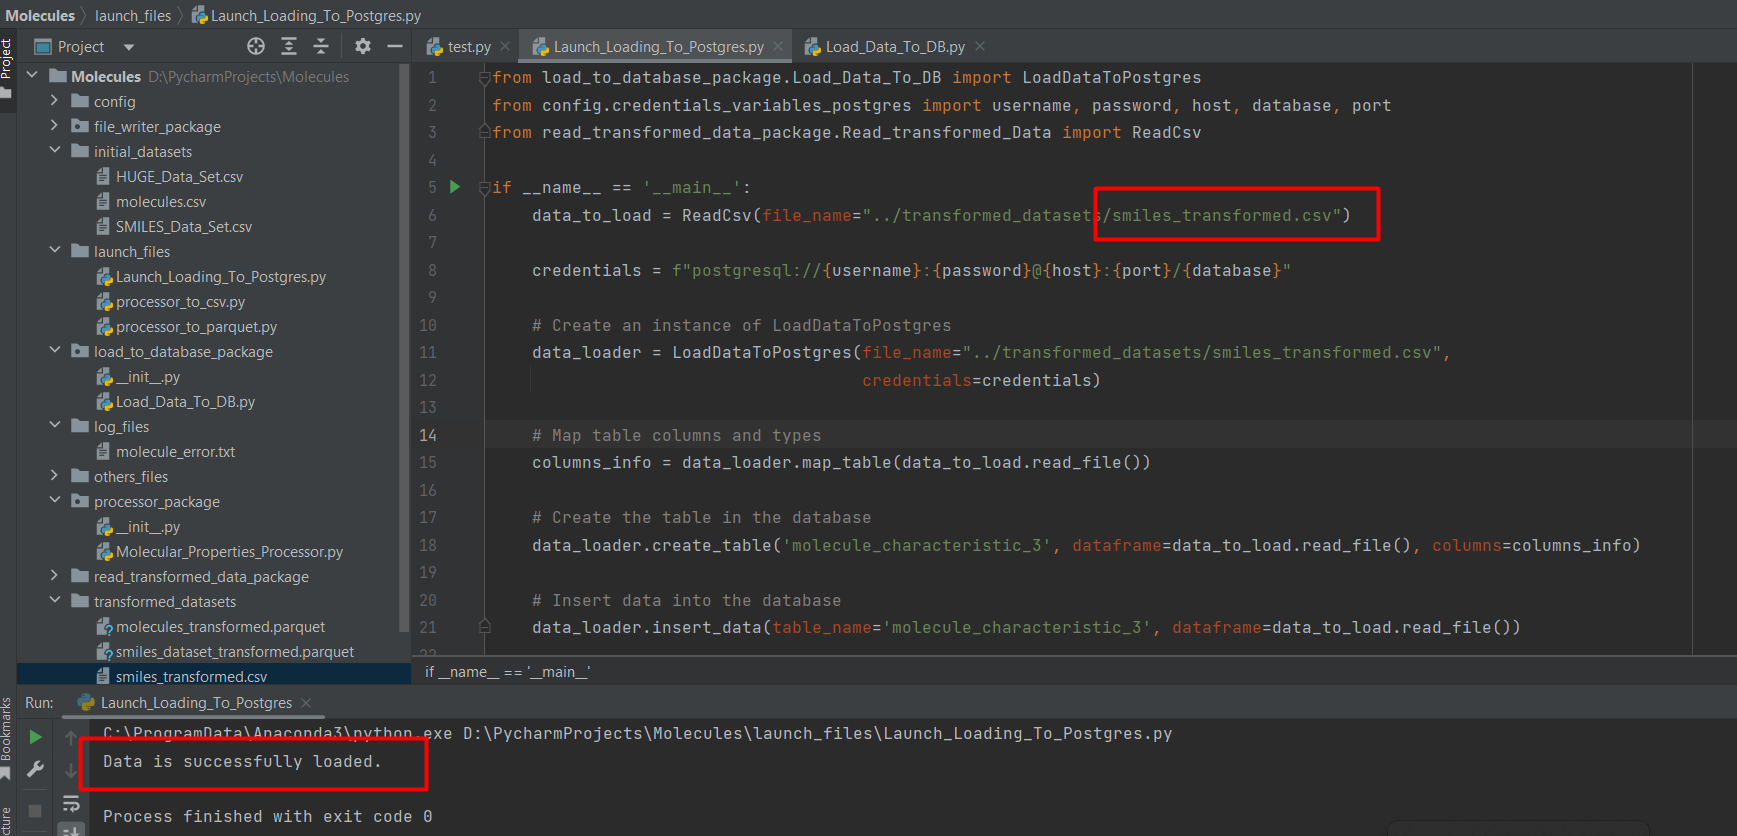

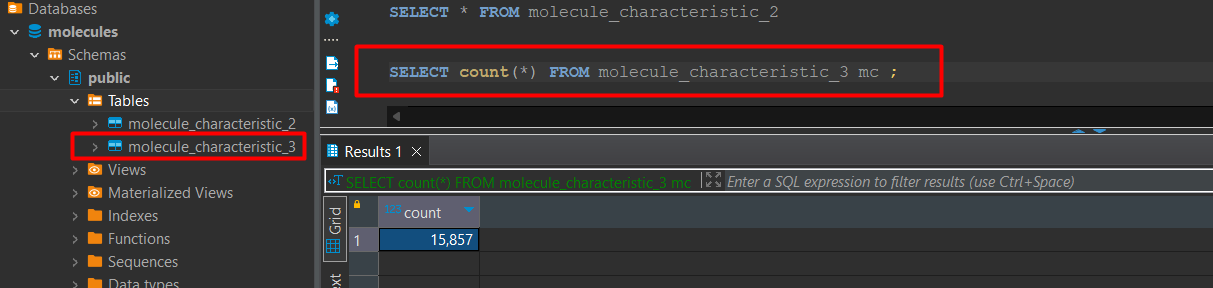

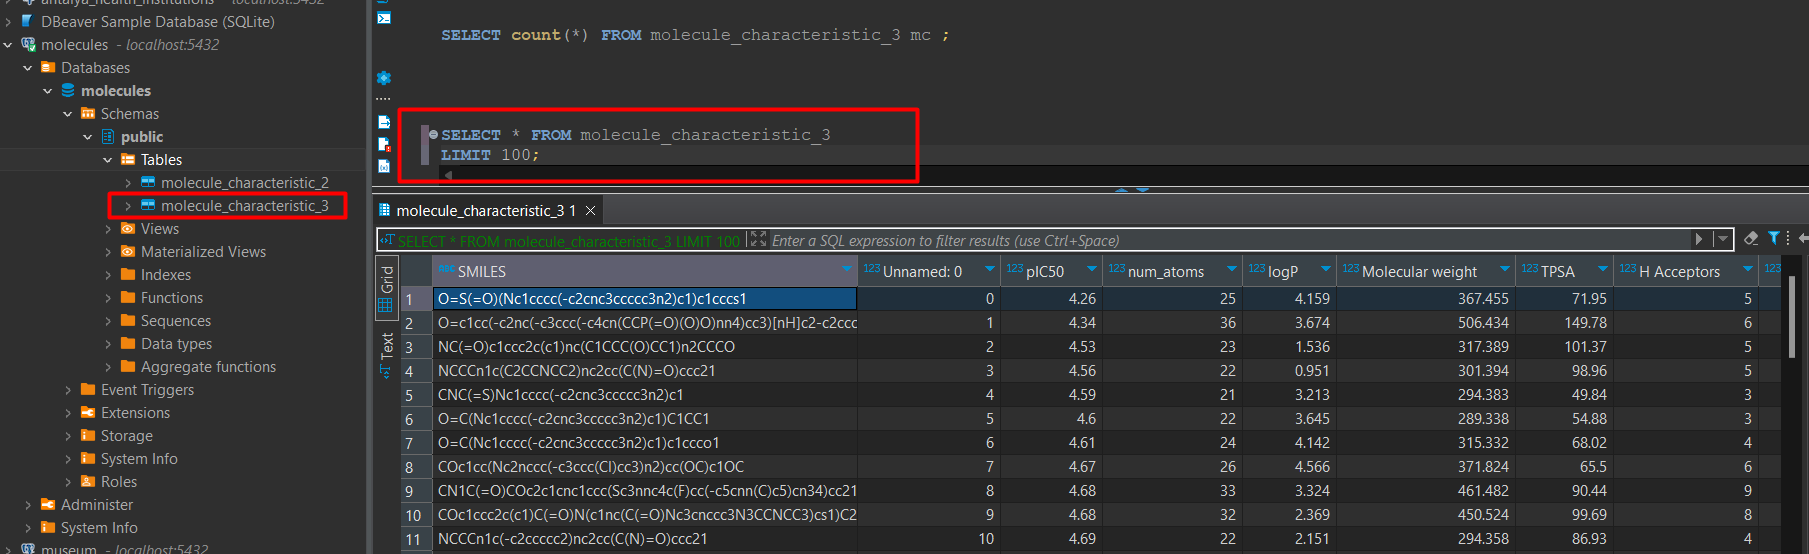